In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch
from torch import nn
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.1.0  Device: cuda


In [0]:
# Params
learning_rate = 0.0001
epoch_size = 30
batch_size = 64

In [3]:
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

batch_size = 64

# CIFAR 10 데이터셋

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(trainset.classes)
class_num = len(trainset.classes)
print(trainset.data.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)


In [5]:
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()        
        # CNN계층들과 Linear 계층을 나누는 것은 중간에서 데이터 shpae을 바꿔주기 위함 
        self.features = nn.Sequential(
            # L1 (C1)
            # input = 227*227*3 
            # F = 96
            # F_size = 11*11*3
            # S = 4
            # O = 27*27*96
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            
            # L2 (M1)
            # input = 55*55*96
            # P = 3*3
            # S = 2
            # O = 27*27*96
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            
            # L3 (C2)
            # input = 27*27*96
            # F = 256
            # F_size = 5*5*96
            # S = 1
            # p = 2
            # O = 27*27*256            
            nn.Conv2d(96, 256, kernel_size=5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            
            # L4 (M2)
            # input = 27*27*256
            # P = 3*3
            # S = 2
            # O = 13*13*256
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # L5 (C3)
            # input = 13*13*256
            # F = 384
            # F_size = 3*3*256
            # S = 1
            # p = 1
            # O = 13*13*384            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # L6 (C4)
            # input = 13*13*384
            # F = 384
            # F_size = 3*3*384
            # S = 1
            # p = 1
            # O = 13*13*384            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # L7 (C5)
            # input = 13*13*384
            # F = 256
            # F_size = 3*3*384
            # S = 1
            # p = 1
            # O = 13*13*256            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # L8 (M3)
            # input = 13*13*256
            # P = 3*3
            # S = 2
            # O = 6*6*256          
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            # L9 (fc1)
            # input = 6*6*256
            # flatten 9216
            # O = (N,4096)
            # N = batch size
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            
            # L10 (fc2)
            # input = (N, 4096)
            # O = (N, 4096)
            # N = input data size
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            # L11 (fc3)
            # input = (N, 4096)
            # O = (N, class number)            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # 데이터를 9216열로 쭉 늘리자
        x = x.view(x.size(0), 256*6*6)
        x = self.classifier(x)
        return x
    
    
model = CNN(10).to(device)
summary(model, (3, 227, 227))

# 각 레이어 별로 친절하게 Filter, H, W 을 표시하고 파라미터 개수까지 보여주고 있습니다.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

In [18]:
# CIFAR 커스텀
# ref: https://github.com/icpm/pytorch-cifar10
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        self.features = nn.Sequential(
            # 정수가 안나오면 shape을 내림으로 처리해주고 있다. 
            nn.Conv2d(3, 96, kernel_size=3, stride=2, padding=1), # Output = 16.5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # stride는 따로 지정안하면 default가 커널 사이즈
            nn.Conv2d(96, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256*2*2, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256*2*2)
        x = self.classifier(x)
        return x
    
model = CNN_CIFAR().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 16, 16]           2,688
              ReLU-2           [-1, 96, 16, 16]               0
         MaxPool2d-3             [-1, 96, 8, 8]               0
            Conv2d-4            [-1, 256, 8, 8]         221,440
              ReLU-5            [-1, 256, 8, 8]               0
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         885,120
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
           Linear-14                 [-

In [0]:
net = CNN_CIFAR().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [24]:
history = {'val_acc': [],'val_loss': []} 


for epoch in range(epoch_size):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    total = 0
    correct = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_loss += loss.item()
        acc = 100*correct/total
        history["val_acc"].append(acc)
        history["val_loss"].append(val_loss / 10)

    if epoch % 10 == 0:
        print('epoch: %d loss: %.3f acc: %.3f ' %
              (epoch, val_loss / 10, acc))
        val_loss = 0.0

epoch: 0 loss: 21.776 acc: 51.170 
epoch: 10 loss: 17.987 acc: 72.200 
epoch: 20 loss: 22.984 acc: 72.530 


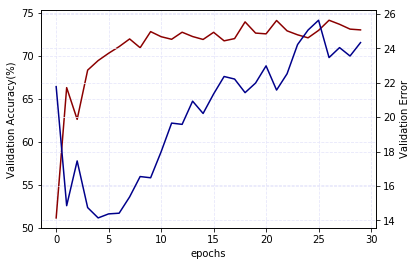

In [25]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
#plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

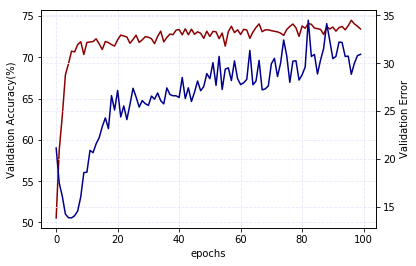
* 기존 NN과제에서 Batch Normalization으로 60까지 찍었는데, 이 모델은 75언저리까지 찍고있습니다.
* epoch이 진행될 수록 과적합이 심해지고 있는데, 모델을 손봐야할지 파라미터를 조정해야할지 고민이 됩니다...